In [21]:
import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
from UnFaIR import *
import scipy as sp
import time

In [2]:
## I think a neat figure would potentially be an exploration of parameter space?

## Get all the data

## Get Law Dome

Law_Dome = pd.read_csv('./Conc_fit_data/law2006.txt',index_col=0,skiprows=183,nrows=2188-184,delim_whitespace=True,usecols=[0,3,5,8],names=['Year','CH4','CO2','N2O'])

# Get NOAA atmospheric observations

obsv_concs = pd.read_csv('./Conc_fit_data/NOAA_Conc_data.csv',skiprows=4,header=None,index_col=0).dropna().iloc[:,:3].values
obsv_concs = pd.DataFrame(data=obsv_concs,index = np.arange(1979,2018),columns=['CO2','CH4','N2O'])

N2O_ems_1890_1990 = pd.read_csv('./Conc_fit_data/edgar_hyde1.4-glob_n2o.csv',index_col=0)
N2O_ems_1970_2012 = pd.read_csv('./Conc_fit_data/v432_N2O_1970_2012.csv',index_col=0)

CH4_ems_1850_2014 = pd.read_csv('./Conc_fit_data/CEDS_CH4_global_emissions_1850_2014.csv',index_col=0,names=['Year','CH4'])
CO2_ems_1750_2014 = pd.read_csv('./Conc_fit_data/CEDS_CO2_global_emissions_1750_2014.csv',index_col=0,names=['Year','CO2'])*(12/44)

RCP85_E = pd.read_csv('./RCP_data/RCP85_EMISSIONS.csv',skiprows=36,index_col=0)
RCP_ems = pd.DataFrame(data = np.array([RCP85_E[['OtherCO2','FossilCO2']].sum(axis=1).values,RCP85_E['CH4'].values,RCP85_E['N2O'].values]).T,columns=['CO2','CH4','N2O'],index = RCP85_E.index)

## Now we need to harmonise the datasets to get a full 1765 - 2015 run

N2O_ems_1890_1970_vals = (N2O_ems_1890_1990.loc[range(1890,1970)] * N2O_ems_1970_2012.loc[1970] / N2O_ems_1890_1990.loc[1970]).values.flatten()
N2O_ems_1765_1890_vals = (RCP_ems.N2O.loc[range(1765,1890)] * N2O_ems_1890_1970_vals[0] / RCP_ems.N2O.loc[1890]).values
N2O_ems_1970_2012_vals = N2O_ems_1970_2012.values.flatten()

N2O_ems_1765_2012 = pd.DataFrame(np.concatenate((N2O_ems_1765_1890_vals,N2O_ems_1890_1970_vals,N2O_ems_1970_2012_vals)),columns=['N2O'],index = np.arange(1765,2013))
N2O_ems_1765_2012 = N2O_ems_1765_2012.interpolate(method='linear',axis=0)


CH4_ems_1850_2014_vals = CH4_ems_1850_2014.drop_duplicates().values.flatten()
CH4_ems_1765_1850_vals = (RCP_ems.CH4.loc[range(1765,1850)] * CH4_ems_1850_2014_vals[0] / RCP_ems.CH4.loc[1850]).values.flatten()

CH4_ems_1765_2014 = pd.DataFrame(np.concatenate((CH4_ems_1765_1850_vals,CH4_ems_1850_2014_vals)),columns=['CH4'],index = np.arange(1765,2015))

CO2_ems_1765_2014 = CO2_ems_1750_2014.loc[1765:] ## Not including OtherCO2 for now? CEDS seems to be fossil co2

emissions = (CO2_ems_1765_2014+pd.DataFrame(data=RCP85_E.OtherCO2.loc[:2014].values,columns=['CO2'],index=CO2_ems_1765_2014.index)).copy()
emissions['CH4'] = CH4_ems_1765_2014
emissions['N2O'] = N2O_ems_1765_2012
emissions['N2O'].loc[2013] = 2*emissions['N2O'].loc[2012] - emissions['N2O'].loc[2011]
emissions['N2O'].loc[2014] = 2*emissions['N2O'].loc[2013] - emissions['N2O'].loc[2012]
emissions['N2O'] = emissions['N2O']*6.6 / emissions.N2O.loc[2010]

/home/nleach/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [3]:
## Get an "other" forcing dataset:
RCP85_forc = pd.read_csv('./Conc_fit_data/RCP85_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)
otherforc = RCP85_forc.TOTAL_INCLVOLCANIC_RF.loc[:2014].values - RCP85_forc.CO2CH4N2O_RF.loc[:2014].values

In [4]:
my_ems_run = UnFaIR(emissions_in=emissions,F_ext=otherforc)
RCP85_ems_run = UnFaIR(emissions_in=RCP_ems.loc[:2014],F_ext=otherforc)

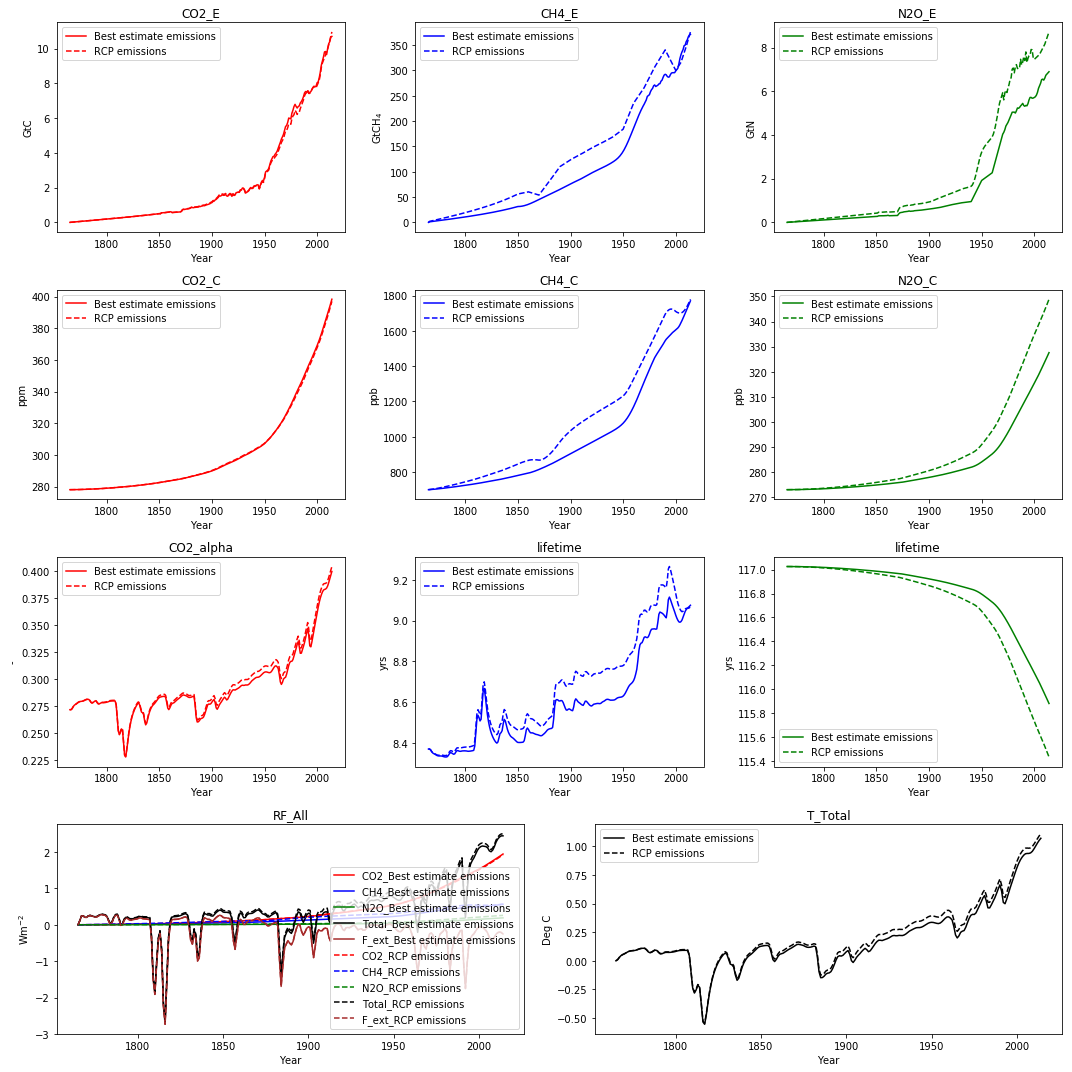

In [5]:
plot_all([my_ems_run,RCP85_ems_run],names=['Best estimate emissions','RCP emissions'])

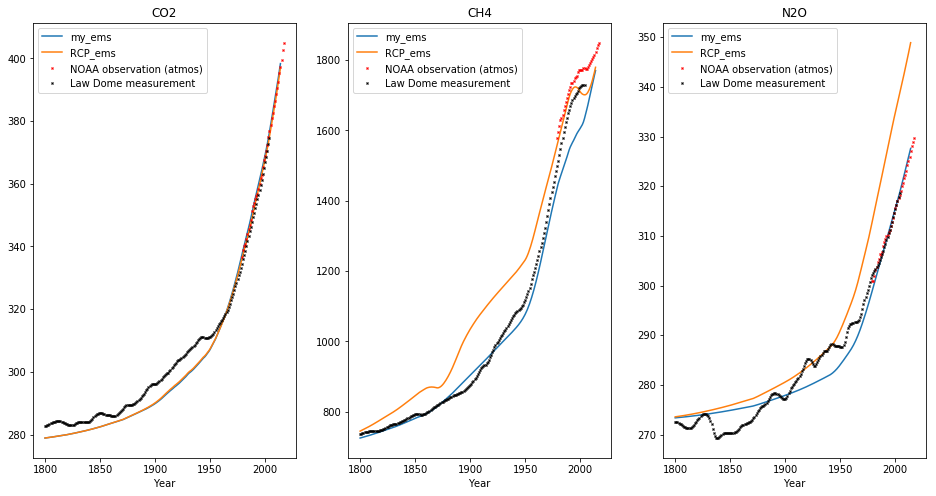

In [6]:
# Plot versus observed concentrations:

fig,ax=plt.subplots(1,3,figsize=(16,8))
for i,s in enumerate(['CO2','CH4','N2O']):
    my_ems_run['C'][s].loc[1800:].plot(ax=ax[i],label='my_ems')
    RCP85_ems_run['C'][s].loc[1800:].plot(ax=ax[i],label='RCP_ems')
    obsv_concs[s].plot(ax=ax[i],marker='x',linewidth=0,ms=2,color='r',label='NOAA observation (atmos)')
    Law_Dome[s].loc[1800:].plot(ax=ax[i],marker='x',linewidth=0,ms=2,color='k', label='Law Dome measurement')
    ax[i].set_title(s)
    ax[i].legend()

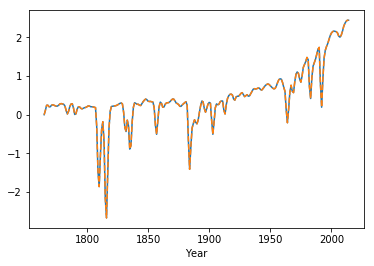

In [7]:
RF_inv = Unstep_temp(my_ems_run['T'])['RF']
fig,ax=plt.subplots()
my_ems_run['RF']['Total'].plot(ax=ax)
RF_inv.plot(linestyle='--')

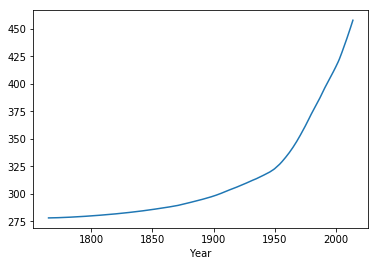

In [8]:
Unstep_forc(my_ems_run['RF']['Total'],F_ext=otherforc)['CO2-fe_C'].plot()

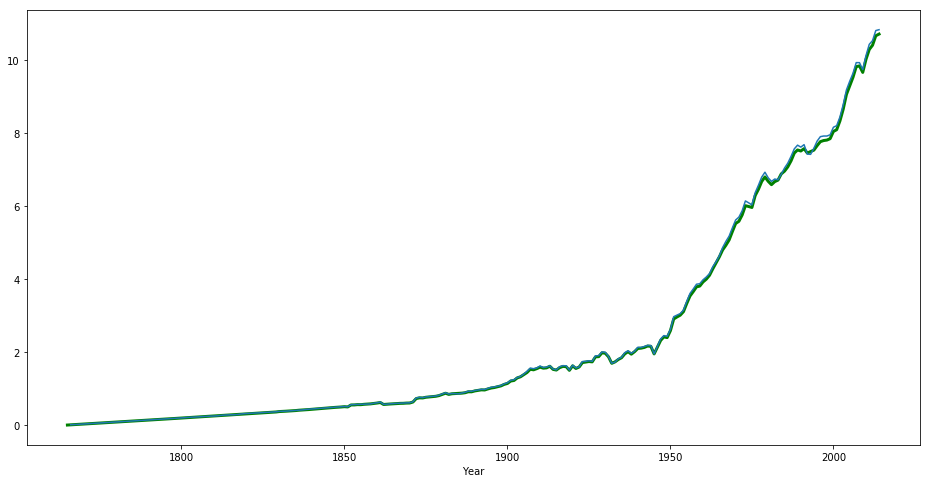

In [9]:
fig=plt.figure(figsize=(16,8))

Unstep_concs(my_ems_run['C']['CO2'],my_ems_run['T']['Total'])['CO2-fe_E'].rolling(2).mean().plot()
my_ems_run['E']['CO2'].plot(linestyle='-',linewidth=3,zorder=1,color='g')

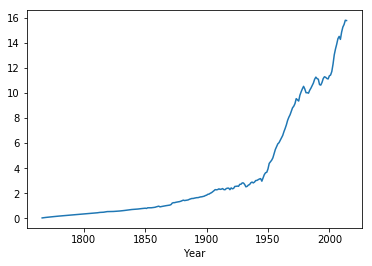

In [19]:
UnUnFaIR(my_ems_run['T'],F_ext=otherforc)['CO2-fe_E'].rolling(2).mean().plot()

In [23]:
## Some run time tests:
start_time = time.time()
for i in np.arange(1000):
    UnFaIR(emissions,otherforc)
print("--- %s seconds ---" % (time.time() - start_time))

--- 154.7954444885254 seconds ---
